In [ ]:
# Goal: 
# Automated detection and classification of cardiac arrhythmias, particularly distinguishing between:
#- Normal heart beats
#- Premature Atrial Contractions (PAC)
#- Other abnormal rhythms

#Technical Outline:
#Creates a deep learning model that achieves 98% accuracy in classifying heart rhythms

#Processes raw ECG data through several steps:
#- QRS complex detection
#- Signal preprocessing and cleaning
#- Feature extraction around R-peaks
#- CNN-based classification

In [ ]:
# MIT-BIH ECG Data Processing and Analysis
# This notebook processes ECG data from the MIT-BIH Arrhythmia Database for rhythm classification.
# https://www.physionet.org/content/mitdb/1.0.0/#files-panel
# downloaded 100 - 109 .atr, .hea, and .dat files

In [1]:
# Import required libraries
import wfdb
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # for progress tracking

# Enable inline plotting for Jupyter
%matplotlib inline

In [3]:
## Data Loading and Preprocessing

In [5]:
def process_ecg_record(record_name):
    # Read record
    record = wfdb.rdrecord(f'data/{record_name}', channel_names=['MLII'])
    annotation = wfdb.rdann(f'data/{record_name}', 'atr')
    
    # Get ECG signal
    ecg_signal = record.p_signal.flatten()
    
    # Process with neurokit2
    signals, info = nk.ecg_process(ecg_signal, sampling_rate=360)
    
    # Get R-peaks
    rpeaks = info['ECG_R_Peaks']
    
    # Get annotations at R-peaks
    beat_annotations = annotation.symbol
    
    return signals, rpeaks, beat_annotations

In [73]:
def extract_qrs_segments(signals, rpeaks, annotations, window_size=WINDOW_SIZE):
    half_window = window_size // 2
    segments = []
    valid_annotations = []
    
    for i, peak in enumerate(rpeaks):
        # Ensure we don't go out of bounds
        if peak - half_window >= 0 and peak + half_window < len(signals['ECG_Clean']):
            segment = signals['ECG_Clean'][peak - half_window:peak + half_window]
            segments.append(segment)
            # Only keep annotations for segments we actually extract
            if i < len(annotations):
                valid_annotations.append(annotations[i])
    
    return np.array(segments), np.array(valid_annotations)

In [7]:
## Test Processing on First Record

In [11]:
# Process first record
record_name = '100'
signals, rpeaks, annotations = process_ecg_record(record_name)

# Print first few annotations to verify
print("First 10 beat annotations:", annotations[:10])

First 10 beat annotations: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']


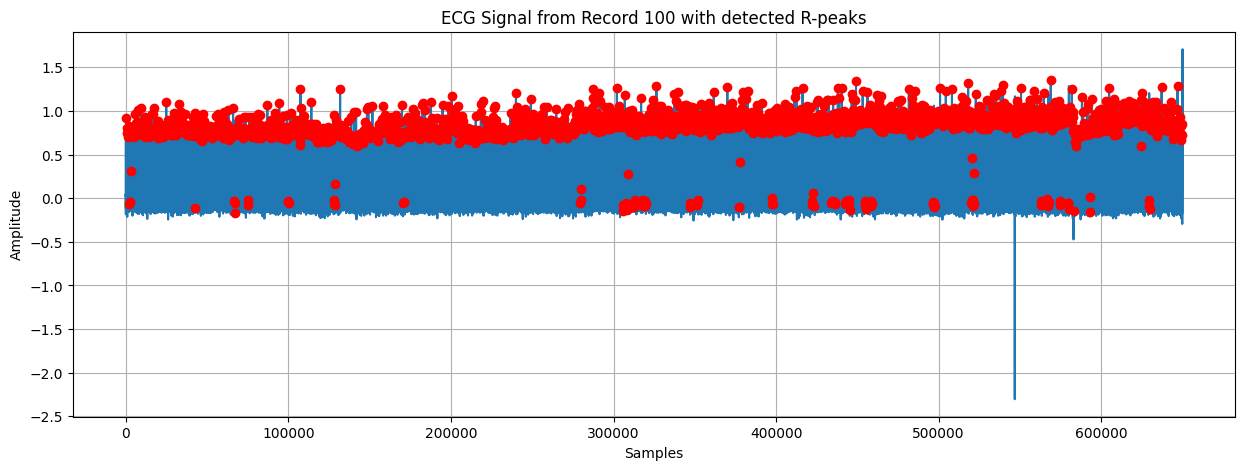

In [13]:
# Visualize the processed signal with R-peaks
plt.figure(figsize=(15, 5))
plt.plot(signals['ECG_Clean'])
plt.plot(rpeaks, signals['ECG_Clean'][rpeaks], 'ro')
plt.title(f'ECG Signal from Record {record_name} with detected R-peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [15]:
## Examine Signal Properties
# Let's look at some basic properties of our processed signal.

In [17]:
# Print signal information
print("Signal shape:", signals['ECG_Clean'].shape)
print("Number of R-peaks detected:", len(rpeaks))
print("Number of annotations:", len(annotations))
print("\nAvailable signal columns:", signals.columns.tolist())

Signal shape: (650000,)
Number of R-peaks detected: 2271
Number of annotations: 2274

Available signal columns: ['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks', 'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial', 'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular', 'ECG_Phase_Completion_Ventricular']


In [21]:
## Next Steps
# 1. Extract features around each QRS complex
# 2. Create labels from annotations
# 3. Prepare batches for CNN training

In [23]:
## Feature Extraction and Data Preparation - Prep the data for our CNN model.

In [25]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [27]:
### 1. Extract QRS Complexes - Create segments around each R-peak

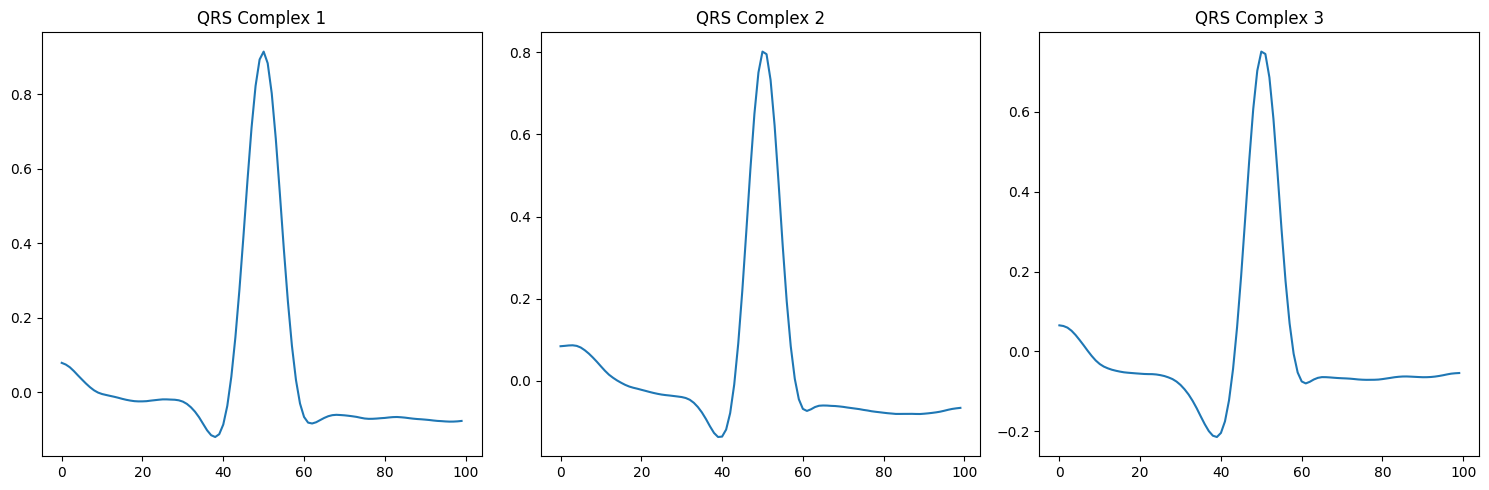

In [43]:
def extract_qrs_segments(signals, rpeaks, window_size=WINDOW_SIZE):
    half_window = window_size // 2
    segments = []
    
    for peak in rpeaks:
        # Ensure we don't go out of bounds
        if peak - half_window >= 0 and peak + half_window < len(signals['ECG_Clean']):
            segment = signals['ECG_Clean'][peak - half_window:peak + half_window]
            segments.append(segment)
    
    return np.array(segments)

# Extract segments
qrs_segments = extract_qrs_segments(signals, rpeaks)

# Visualize a few segments
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(qrs_segments[i])
    plt.title(f'QRS Complex {i+1}')
plt.tight_layout()
plt.show()

In [61]:
# Define window size around R-peaks (samples before and after R-peak)
WINDOW_SIZE = 100  # 50 samples before and after R-peak

def extract_qrs_segments(signals, rpeaks, annotations, window_size=WINDOW_SIZE):
    half_window = window_size // 2
    segments = []
    valid_annotations = []
    
    for i, peak in enumerate(rpeaks):
        # Ensure we don't go out of bounds
        if peak - half_window >= 0 and peak + half_window < len(signals['ECG_Clean']):
            segment = signals['ECG_Clean'][peak - half_window:peak + half_window]
            segments.append(segment)
            # Only keep annotations for segments we actually extract
            if i < len(annotations):
                valid_annotations.append(annotations[i])
    
    return np.array(segments), np.array(valid_annotations)

In [63]:
# Process first record
record_name = '100'
signals, rpeaks, annotations = process_ecg_record(record_name)

# Extract segments with corresponding annotations
qrs_segments, valid_annotations = extract_qrs_segments(signals, rpeaks, annotations)

# Verify lengths match
print("Number of segments:", len(qrs_segments))
print("Number of annotations:", len(valid_annotations))

Number of segments: 2271
Number of annotations: 2271


In [64]:
### 2. Create Labels from Annotations - Focus on key rhythm types for classification

In [65]:
def create_labels(annotations):
    # Map common annotations to simplified classes
    rhythm_mapping = {
        'N': 'Normal',  # Normal beat
        'V': 'PVC',     # Premature ventricular contraction
        'A': 'PAC',     # Premature atrial contraction
        'L': 'Normal',  # Left bundle branch block
        'R': 'Normal',  # Right bundle branch block
        '/': 'Paced',   # Paced beat
    }
    
    labels = []
    for ann in annotations:
        labels.append(rhythm_mapping.get(ann, 'Other'))
    
    return np.array(labels)

# Create labels from valid annotations
labels = create_labels(valid_annotations)

# Print distribution of classes
unique, counts = np.unique(labels, return_counts=True)
print("\nClass distribution:")
for cls, count in zip(unique, counts):
    print(f"{cls}: {count}")


Class distribution:
Normal: 2236
Other: 1
PAC: 33
PVC: 1


In [66]:
### 3. Prepare Data for CNN Training

In [69]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create PyTorch dataset class
class ECGDataset(Dataset):
    def __init__(self, segments, labels):
        self.segments = torch.FloatTensor(segments)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.segments)
    
    def __getitem__(self, idx):
        return self.segments[idx], self.labels[idx]

# Filter out classes with too few samples (keep only Normal and PAC)
mask = (labels == 'Normal') | (labels == 'PAC')
filtered_segments = qrs_segments[mask]
filtered_labels = labels[mask]

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(filtered_labels)

# Split data without stratification
X_train, X_test, y_train, y_test = train_test_split(
    filtered_segments, 
    encoded_labels, 
    test_size=0.2, 
    random_state=42
)

# Create datasets
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("\nDataset sizes:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Verify batch shapes
for batch_segments, batch_labels in train_loader:
    print("\nBatch shapes:")
    print(f"Segments shape: {batch_segments.shape}")
    print(f"Labels shape: {batch_labels.shape}")
    break

# Print class distribution in training set
unique, counts = np.unique(y_train, return_counts=True)
print("\nTraining set class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {label_encoder.inverse_transform([u])[0]}: {c}")


Dataset sizes:
Training samples: 1815
Testing samples: 454

Batch shapes:
Segments shape: torch.Size([32, 100])
Labels shape: torch.Size([32])

Training set class distribution:
Class Normal: 1794
Class PAC: 21


In [ ]:
# Dataset has a clear class imbalance (98.8% Normal vs 1.2% PAC)

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report

# Define the CNN Model
class ECGClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ECGClassifier, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5)
        
        # Pooling layer
        self.pool = nn.MaxPool1d(2)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        
        # Calculate the size of flattened features
        self._to_linear = None
        self._get_conv_output_size((1, 100))
        
        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def _get_conv_output_size(self, shape):
        bs = 1
        input = torch.randn(bs, *shape)
        output = self._forward_conv(input)
        self._to_linear = int(np.prod(output.shape))
        
    def _forward_conv(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        return x
    
    def forward(self, x):
        # Add channel dimension
        x = x.unsqueeze(1)
        
        # Convolutional layers
        x = self._forward_conv(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_segments, batch_labels in train_loader:
        batch_segments = batch_segments.to(device)
        batch_labels = batch_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_segments)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_segments, batch_labels in test_loader:
            batch_segments = batch_segments.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_segments)
            loss = criterion(outputs, batch_labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc, all_predictions, all_labels

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model and move to device
num_classes = len(np.unique(y_train))
model = ECGClassifier(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50
best_test_acc = 0.0

# Training loop
print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc, predictions, true_labels = evaluate_model(model, test_loader, criterion, device)
    
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print('-' * 60)

# Print final classification report
print("\nFinal Classification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=label_encoder.classes_))

Using device: cpu
Starting training...
Epoch [1/50]
Train Loss: 0.1286, Train Acc: 98.84%
Test Loss: 0.1342, Test Acc: 97.36%
------------------------------------------------------------
Epoch [2/50]
Train Loss: 0.0454, Train Acc: 98.84%
Test Loss: 0.0677, Test Acc: 97.36%
------------------------------------------------------------
Epoch [3/50]
Train Loss: 0.0392, Train Acc: 98.90%
Test Loss: 0.0837, Test Acc: 97.36%
------------------------------------------------------------
Epoch [4/50]
Train Loss: 0.0422, Train Acc: 98.84%
Test Loss: 0.0727, Test Acc: 97.36%
------------------------------------------------------------
Epoch [5/50]
Train Loss: 0.0414, Train Acc: 98.73%
Test Loss: 0.0787, Test Acc: 97.36%
------------------------------------------------------------
Epoch [6/50]
Train Loss: 0.0401, Train Acc: 98.84%
Test Loss: 0.0637, Test Acc: 97.36%
------------------------------------------------------------
Epoch [7/50]
Train Loss: 0.0407, Train Acc: 98.84%
Test Loss: 0.0984, Tes

In [ ]:
# The model achieved a high overall accuracy of 98% across all samples (454 test cases)
# While the model is precise with PAC detection (no false positives), it misses many PAC cases (low recall)
# The weighted average metrics are high (0.98) due to the dominance of the Normal class in the dataset

# Improvements: The model's performance on PAC detection could be improved